In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
import sys
import os
import struct
import pywt
import concurrent.futures
import glob
from windrose import WindroseAxes
import cmcrameri as cmc
from cmcrameri import cm
from scipy.stats import linregress
from scipy.signal import welch, csd
from datetime import datetime
from scipy.optimize import curve_fit
import pickle



sys.path.append(os.path.join(os.getcwd(), 'EC'))
sys.path.append(os.path.join(os.getcwd(), 'plotting'))
sys.path.append(os.path.join(os.getcwd(), 'MO'))
sys.path.append(os.path.join(os.getcwd(), 'SPC'))

import constants
import Func_read_data
import Func_despike_data
import sensor_info
import Func_DR
import Func_MRFD
import Funcs_plots
import normalize
import Func_MO

importlib.reload(Func_read_data)
importlib.reload(Func_despike_data)
importlib.reload(constants)
importlib.reload(sensor_info)
importlib.reload(Func_DR)
importlib.reload(Func_MRFD)
importlib.reload(Funcs_plots)
importlib.reload(normalize)
importlib.reload(Func_MO)

from Func_read_data import *
from constants import *
from Func_despike_data import *
from sensor_info import *
from Func_MRFD import *
from Func_DR import *
from Funcs_plots import *
from normalize import *
from Func_MO import *

In [2]:
fs=10
def compute_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    return f, coh, y, a_best
def plot_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    # Convert frequency to period in seconds, avoid division by zero
    period = np.where(f > 0, 1 / f, np.nan)
    plt.semilogx(period, coh, label=fr'{label} $|\mathrm{{S}}_{{ij}}|^2/(\mathrm{{S}}_i \mathrm{{S}}_j)$', color=color)
    plt.semilogx(period, y, '--', label=f'{label} Fit: a={a_best:.2f}', color=color)
    plt.gca().invert_xaxis()

In [3]:

def load_fastdata(folder, start, end):
    start_dt = datetime.strptime(start, '%Y-%m-%d_%H:%M:%S')
    end_dt = datetime.strptime(end, '%Y-%m-%d_%H:%M:%S')
    all_dfs = []
    for root, dirs, files in os.walk(folder):
        files = sorted(files)
        for file in files:
            if file.endswith('.dat'):
                try:
                    date_str = file.split('_')[-2] + '_' + file.split('_')[-1].split('.')[0]
                    file_dt = datetime.strptime(date_str, '%Y-%m-%d_%H%M')
                    if start_dt <= file_dt <= end_dt:
                        file_path = os.path.join(root, file)
                        # print(f"Processing file: {file_path}")
                        df = pd.read_csv(file_path, index_col=0, parse_dates=True, sep='\t')
                        df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
                        all_dfs.append(df)
                except Exception:
                    pass
    if all_dfs:
        return pd.concat(all_dfs)
    else:
        return pd.DataFrame()


In [4]:
wd1_45_90_periods

NameError: name 'wd1_45_90_periods' is not defined

In [5]:
start='2024-08-17_00:00:00'
end='2024-08-18_06:00:00'
import pickle

# Load the list from the file
with open('wd1_45_90_periods.pkl', 'rb') as f:
    wd1_45_90_periods = pickle.load(f)
with open('wd1_90_180_periods.pkl', 'rb') as f:
    wd1_90_180_periods = pickle.load(f)
# Load the list from the file
with open('stability_0_02_periods.pkl', 'rb') as f:
    stability_0_02_periods= pickle.load(f)
with open('stability_02_10_periods.pkl', 'rb') as f:
    stability_02_10_periods = pickle.load(f)



fastdata_SFC_periods = []
fastdata_16_periods = []
fastdata_26_periods = []

for period_start, period_end in stability_0_02_periods[0:15]:
    # fastdata_SFC_periods = []
    # fastdata_16_periods = []
    # fastdata_26_periods = []
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    print(f"Processing period: {start_str} to {end_str}")
    
    # Load and append data for each period
    sfc_df = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/', start_str, end_str)
    fastdata_SFC_periods.append(sfc_df)
    df_16 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/', start_str, end_str)
    fastdata_16_periods.append(df_16)
    df_26 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', start_str, end_str)
    fastdata_26_periods.append(df_26)

# After the loop, concatenate all periods into one continuous DataFrame for each height
fastdata_SFC_all = pd.concat(fastdata_SFC_periods, axis=0)
fastdata_16_all = pd.concat(fastdata_16_periods, axis=0)
fastdata_26_all = pd.concat(fastdata_26_periods, axis=0)
plt.figure(figsize=(10, 5))

# Check if data is empty before plotting
try:
    u1 = fastdata_SFC_periods[0]['Ux']
    u2 = fastdata_16_periods[0]['Ux']
    u3 = fastdata_26_periods[0]['Ux']
    if u1.empty or u2.empty or u3.empty:
        print("One or more dataframes are empty, skipping this period.")
        continue
    plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
    plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
    plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
    plt.xlabel('Frequency [s]')
    plt.ylabel('Coherence')
    plt.title(f'Vertical Coherence of Streamwise Velocity z/L 0.2-10 {period_start}-{period_end}')
    # plt.legend()
    # plt.savefig(f'./plots_coherence/coherence_plot_zl0.2_10_{start_str}_{end_str}.png', dpi=300)
    # plt.show()
except Exception as e:
    print(f"Error during plotting for period {start_str} to {end_str}: {e}")
    continue
plt.show()

Processing period: 2024-01-24_07:00:00 to 2024-01-24_19:00:00
Processing period: 2024-01-25_04:30:00 to 2024-01-25_17:00:00
Processing period: 2024-01-30_11:00:00 to 2024-02-01_08:00:00
Processing period: 2024-02-06_23:00:00 to 2024-02-10_01:00:00


KeyboardInterrupt: 

/tmp/ipykernel_746158/1122742076.py:23: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


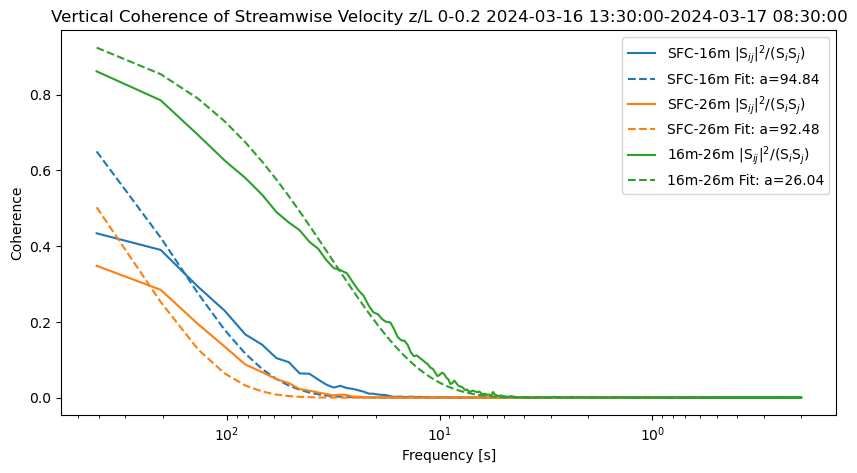

In [21]:
plt.figure(figsize=(10, 5))

# Check if data is empty before plotting
u1 = fastdata_SFC_all['Ux']
u2 = fastdata_16_all['Ux']
u3 = fastdata_26_all['Ux']
if u1.empty or u2.empty or u3.empty:
    print("One or more dataframes are empty, skipping this period.")
plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
plt.xlabel('Frequency [s]')
plt.ylabel('Coherence')
plt.title(f'Vertical Coherence of Streamwise Velocity z/L 0-0.2 {period_start}-{period_end}')
plt.legend()
plt.savefig(f'./plots_coherence/coherence_plot_zl0_0.2_{start_str}_{end_str}.png', dpi=300)
# plt.show()

/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:53: RuntimeWarning:

Skipping event 2024-12-01_01:01:00 to 2024-12-02_09:24:00 due to empty data.
Skipping event 2024-12-02_09:25:00 to 2024-12-02_23:05:00 due to empty data.
Skipping event 2024-12-03_06:37:00 to 2024-12-03_23:25:00 due to empty data.
Skipping event 2024-12-04_02:23:00 to 2024-12-04_17:41:00 due to empty data.
Skipping event 2024-12-08_05:20:00 to 2024-12-08_18:20:00 due to empty data.


/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_421133/3292876197.py:91: RuntimeWarning:

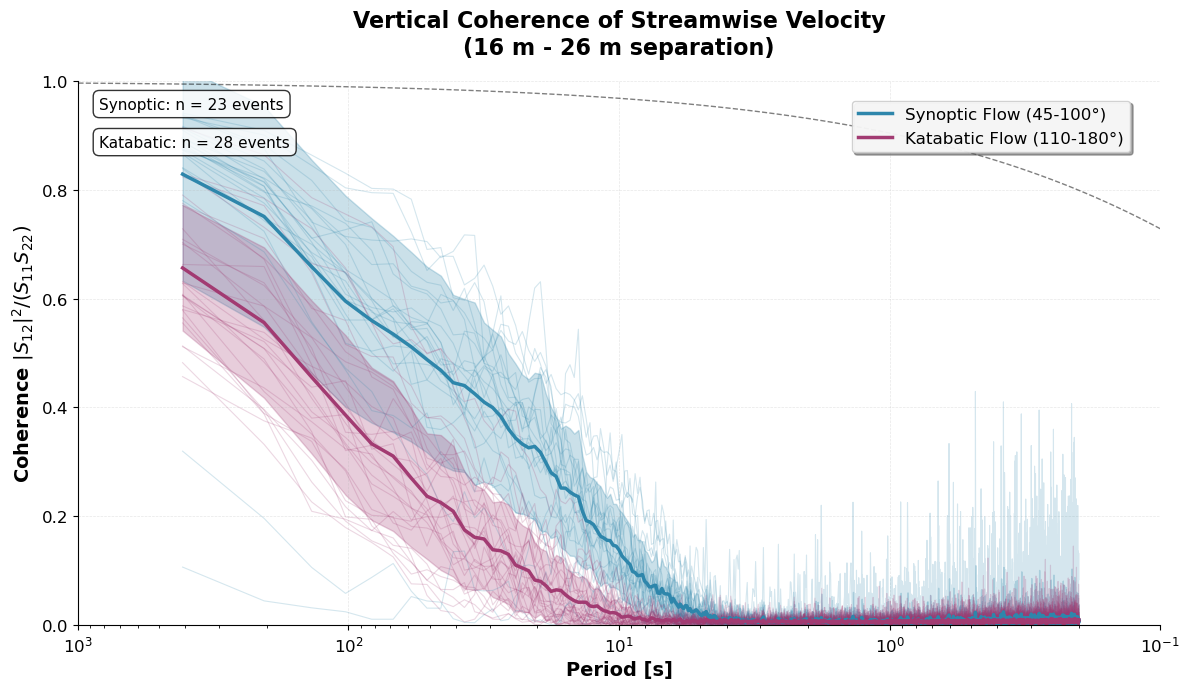

In [10]:
# Load the data
with open('wd1_45_90_periods.pkl', 'rb') as f:
    wd1_45_90_periods = pickle.load(f)
with open('wd1_90_180_periods.pkl', 'rb') as f:
    wd1_90_180_periods = pickle.load(f)
with open('stability_0_02_periods.pkl', 'rb') as f:
    stability_0_02_periods = pickle.load(f)
with open('stability_02_10_periods.pkl', 'rb') as f:
    stability_02_10_periods = pickle.load(f)

# Set up the figure with scientific styling
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 7))

# Define scientific color scheme
colors = {
    'synoptic': {'main': '#2E86AB', 'fill': '#2E86AB', 'alpha': 0.25},
    'katabatic': {'main': '#A23B72', 'fill': '#A23B72', 'alpha': 0.25}
}

# Store all coherence curves for each wind direction regime
synoptic_coh = []
synoptic_period = []
katabatic_coh = []
katabatic_period = []

# Process synoptic flow periods (45-90°)
for period_start, period_end in wd1_45_90_periods:
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    
    try:
        sfc_df = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/', start_str, end_str)
        df_16 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', start_str, end_str)
        
        if sfc_df.empty or df_16.empty:
            print(f"Skipping event {start_str} to {end_str} due to empty data.")
            continue
            
        u1, u2 = sfc_df['Ux'], df_16['Ux']
        
        # Align and clean data
        u1_clean, u2_clean = u1.align(u2, join='inner')
        mask = (~u1_clean.isna()) & (~u2_clean.isna())
        u1_clean = u1_clean[mask]
        u2_clean = u2_clean[mask]
        
        # Compute coherence
        f, S11 = welch(u1_clean, fs=fs, nperseg=4096)
        _, S22 = welch(u2_clean, fs=fs, nperseg=4096)
        _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg=4096)
        coh = np.abs(S12)**2 / (S11 * S22)
        period = np.where(f > 0, 1 / f, np.nan)
        
        synoptic_coh.append(coh)
        synoptic_period.append(period)
        
        # Plot individual curves with low alpha
        ax.semilogx(period, coh, color=colors['synoptic']['main'], alpha=0.2, linewidth=0.8)
        
    except Exception as e:
        print(f"Error during synoptic event {start_str} to {end_str}: {e}")
        continue

# Process katabatic flow periods (90-180°)
for period_start, period_end in wd1_90_180_periods:
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    
    try:
        sfc_df = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/', start_str, end_str)
        df_16 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', start_str, end_str)
        
        if sfc_df.empty or df_16.empty:
            print(f"Skipping event {start_str} to {end_str} due to empty data.")
            continue
            
        u1, u2 = sfc_df['Ux'], df_16['Ux']
        
        # Align and clean data
        u1_clean, u2_clean = u1.align(u2, join='inner')
        mask = (~u1_clean.isna()) & (~u2_clean.isna())
        u1_clean = u1_clean[mask]
        u2_clean = u2_clean[mask]
        
        # Compute coherence
        f, S11 = welch(u1_clean, fs=fs, nperseg=4096)
        _, S22 = welch(u2_clean, fs=fs, nperseg=4096)
        _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg=4096)
        coh = np.abs(S12)**2 / (S11 * S22)
        period = np.where(f > 0, 1 / f, np.nan)
        
        katabatic_coh.append(coh)
        katabatic_period.append(period)
        
        # Plot individual curves with low alpha
        ax.semilogx(period, coh, color=colors['katabatic']['main'], alpha=0.2, linewidth=0.8)
        
    except Exception as e:
        print(f"Error during katabatic event {start_str} to {end_str}: {e}")
        continue

# Calculate and plot envelopes for synoptic flow
if len(synoptic_coh) > 0:
    synoptic_coh = np.array([c for c in synoptic_coh if c.size > 0])
    synoptic_period = np.array([p for p in synoptic_period if p.size > 0])
    
    if len(synoptic_coh) > 0:
        period_ref = synoptic_period[0]
        coh_mean = np.nanmean(synoptic_coh, axis=0)
        coh_std = np.nanstd(synoptic_coh, axis=0)
        coh_min = np.nanmin(synoptic_coh, axis=0)
        coh_max = np.nanmax(synoptic_coh, axis=0)
        
        # Plot mean and envelope
        ax.semilogx(period_ref, coh_mean, color=colors['synoptic']['main'], 
                   linewidth=2.5, label='Synoptic Flow (45-100°)')
        ax.fill_between(period_ref, coh_mean - coh_std, coh_mean + coh_std, 
                       color=colors['synoptic']['fill'], alpha=colors['synoptic']['alpha'])

# Calculate and plot envelopes for katabatic flow
if len(katabatic_coh) > 0:
    katabatic_coh = np.array([c for c in katabatic_coh if c.size > 0])
    katabatic_period = np.array([p for p in katabatic_period if p.size > 0])
    
    if len(katabatic_coh) > 0:
        period_ref = katabatic_period[0]
        coh_mean = np.nanmean(katabatic_coh, axis=0)
        coh_std = np.nanstd(katabatic_coh, axis=0)
        coh_min = np.nanmin(katabatic_coh, axis=0)
        coh_max = np.nanmax(katabatic_coh, axis=0)
        
        # Plot mean and envelope
        ax.semilogx(period_ref, coh_mean, color=colors['katabatic']['main'], 
                   linewidth=2.5, label='Katabatic Flow (110-180°)')
        ax.fill_between(period_ref, coh_mean - coh_std, coh_mean + coh_std, 
                       color=colors['katabatic']['fill'], alpha=colors['katabatic']['alpha'])

# Scientific formatting
ax.set_xlabel('Period [s]', fontsize=14, fontweight='bold')
ax.set_ylabel('Coherence $|S_{12}|^2/(S_{11}S_{22})$', fontsize=14, fontweight='bold')
ax.set_title('Vertical Coherence of Streamwise Velocity\n(16 m - 26 m separation)', 
             fontsize=16, fontweight='bold', pad=20)

# Set axis limits and grid
ax.set_xlim(0.1, 1000)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Add legend
legend = ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
                  loc='upper right', bbox_to_anchor=(0.98, 0.98))
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# Add sample size annotations
n_synoptic = len(synoptic_coh) if len(synoptic_coh) > 0 else 0
n_katabatic = len(katabatic_coh) if len(katabatic_coh) > 0 else 0

ax.text(0.02, 0.95, f'Synoptic: n = {n_synoptic} events', 
        transform=ax.transAxes, fontsize=11, 
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
ax.text(0.02, 0.88, f'Katabatic: n = {n_katabatic} events', 
        transform=ax.transAxes, fontsize=11, 
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

# Add theoretical reference lines
period_theory = np.logspace(-1, 3, 100)
# Taylor's hypothesis: coherence ~ exp(-const * dz * f / U)
# For reference, add a typical decay curve
ax.semilogx(period_theory, np.exp(-0.1 * period_theory**(-0.5)), 
           'k--', alpha=0.5, linewidth=1, label='Theoretical decay')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Invert x-axis to show increasing period
ax.invert_xaxis()

plt.tight_layout()
plt.savefig('./plots_coherence/14_wd45_180_16_26.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

Processing period: 2024-09-19_08:30:00 to 2024-09-20_18:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


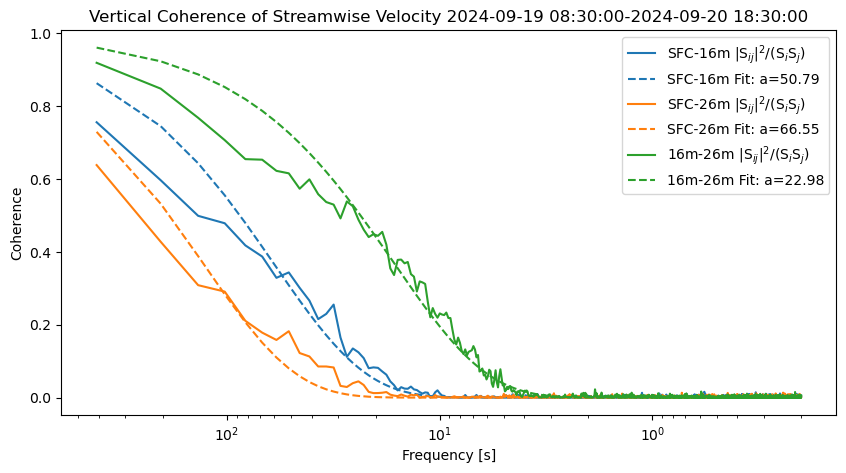

Processing period: 2024-10-16_02:30:00 to 2024-10-17_04:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


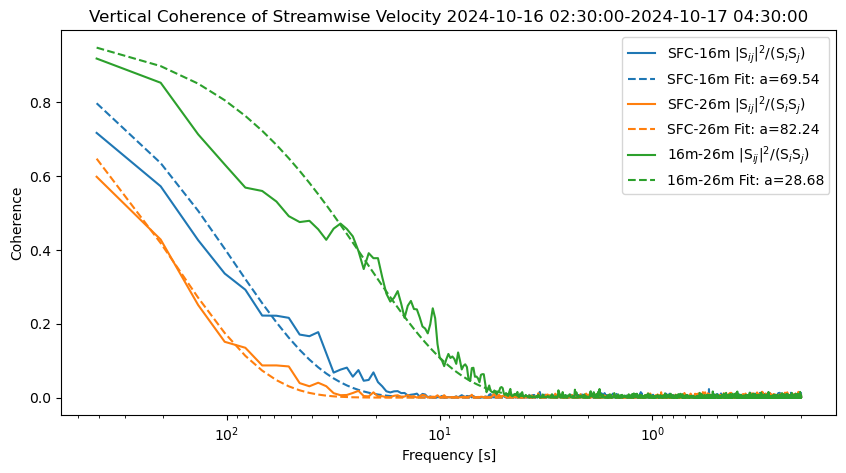

Processing period: 2024-10-28_16:00:00 to 2024-10-29_22:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


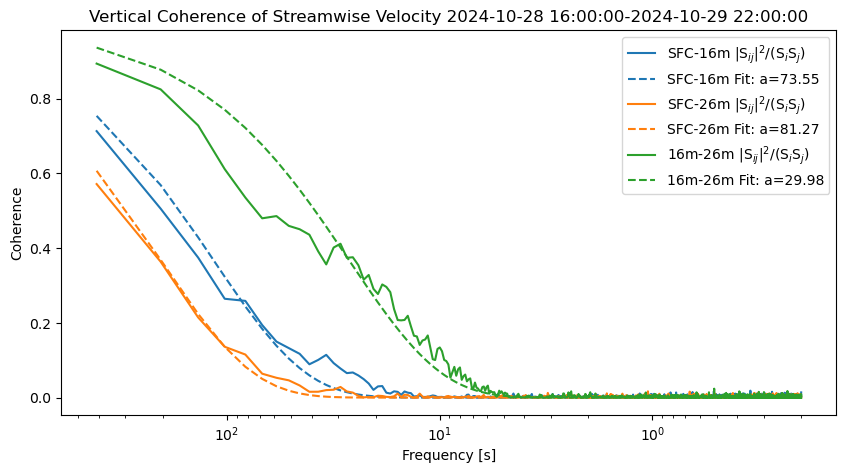

Processing period: 2024-04-18_19:00:00 to 2024-04-21_11:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


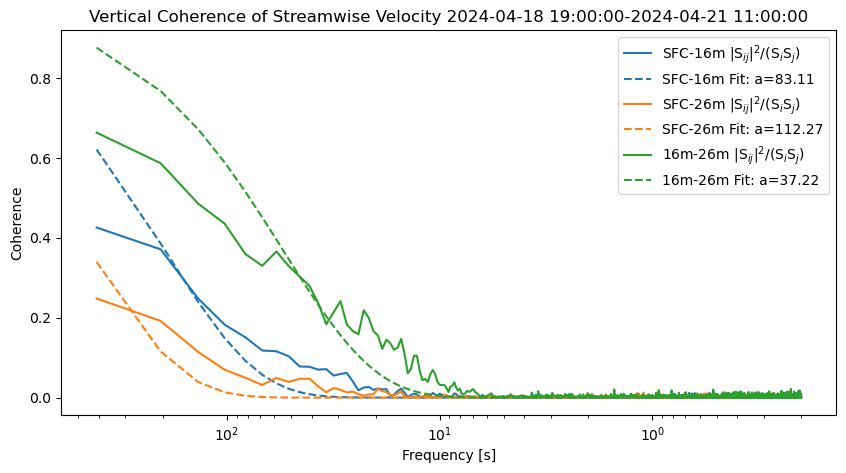

Processing period: 2024-06-08_22:00:00 to 2024-06-09_23:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


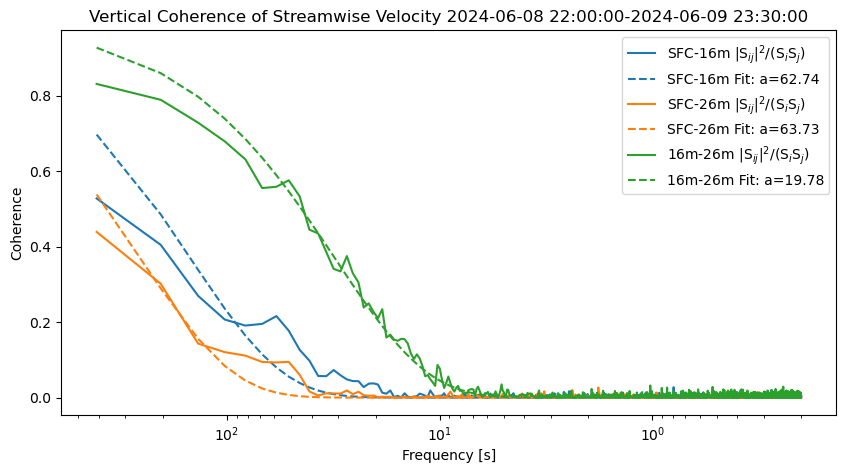

Processing period: 2024-11-06_13:30:00 to 2024-11-07_21:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


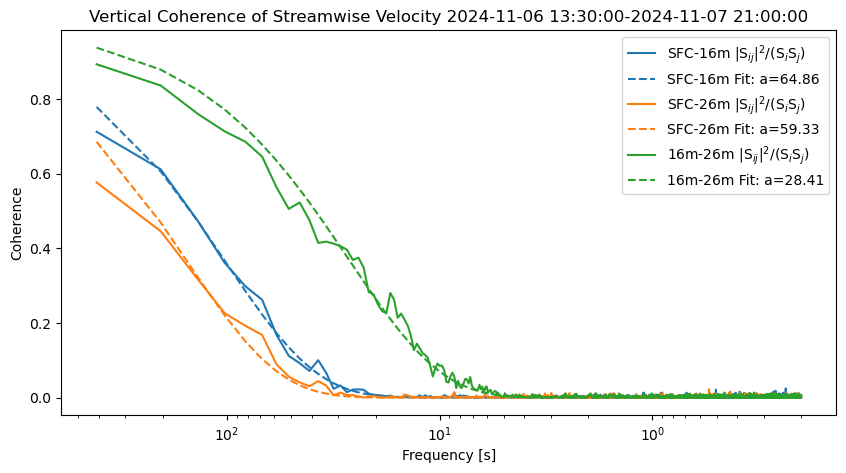

In [46]:
with open('events.pkl', 'rb') as f:
    events = pickle.load(f)
    
for period_start, period_end in events:
    fastdata_SFC_periods = []
    fastdata_16_periods = []
    fastdata_26_periods = []
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    print(f"Processing period: {start_str} to {end_str}")
    
    # Load and append data for each period
    sfc_df = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/SFC_DR/', start_str, end_str)
    fastdata_SFC_periods.append(sfc_df)
    df_16 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m_DR/', start_str, end_str)
    fastdata_16_periods.append(df_16)
    df_26 = load_fastdata('/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_DR/', start_str, end_str)
    fastdata_26_periods.append(df_26)

    # After the loop, concatenate all periods into one continuous DataFrame for each height
    fastdata_SFC_all = pd.concat(fastdata_SFC_periods, axis=0)
    fastdata_16_all = pd.concat(fastdata_16_periods, axis=0)
    fastdata_26_all = pd.concat(fastdata_26_periods, axis=0)
    plt.figure(figsize=(10, 5))

    # Check if data is empty before plotting
    try:
        u1 = fastdata_SFC_periods[0]['Ux']
        u2 = fastdata_16_periods[0]['Ux']
        u3 = fastdata_26_periods[0]['Ux']
        if u1.empty or u2.empty or u3.empty:
            print("One or more dataframes are empty, skipping this period.")
            continue
        plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
        plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
        plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
        plt.xlabel('Frequency [s]')
        plt.ylabel('Coherence')
        plt.title(f'Vertical Coherence of Streamwise Velocity {period_start}-{period_end}')
        plt.legend()
        plt.savefig(f'./plots_specific_events/coherence_plot_zl0.2_10_{start_str}_{end_str}.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error during plotting for period {start_str} to {end_str}: {e}")
        continue
    plt.show()

/tmp/ipykernel_746158/1122742076.py:23: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


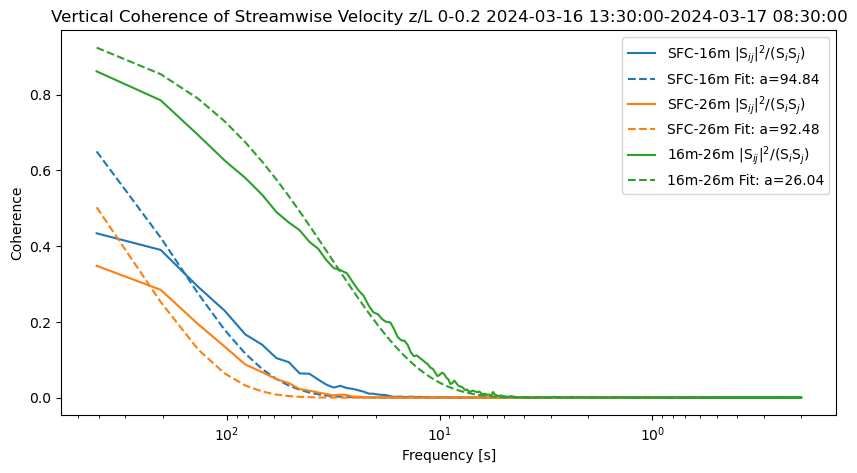

In [19]:
fs=10
def plot_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    # Convert frequency to period in seconds, avoid division by zero
    period = np.where(f > 0, 1 / f, np.nan)
    plt.semilogx(period, coh, label=fr'{label} $|\mathrm{{S}}_{{ij}}|^2/(\mathrm{{S}}_i \mathrm{{S}}_j)$', color=color)
    plt.semilogx(period, y, '--', label=f'{label} Fit: a={a_best:.2f}', color=color)
    plt.gca().invert_xaxis()


plt.figure(figsize=(10, 5))
plot_coherence(fastdata_SFC['Ux'], fastdata_16['Ux'], dz=14, label='SFC-16m', color='tab:blue')
plot_coherence(fastdata_SFC['Ux'], fastdata_26['Ux'], dz=24, label='SFC-26m', color='tab:orange')
plot_coherence(fastdata_16['Ux'], fastdata_26['Ux'], dz=10, label='16m-26m', color='tab:green')
plt.xlabel('Frequency [s]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity')
plt.legend()
plt.show()


NameError: name 'fastdata_SFC' is not defined

<Figure size 1000x500 with 0 Axes>

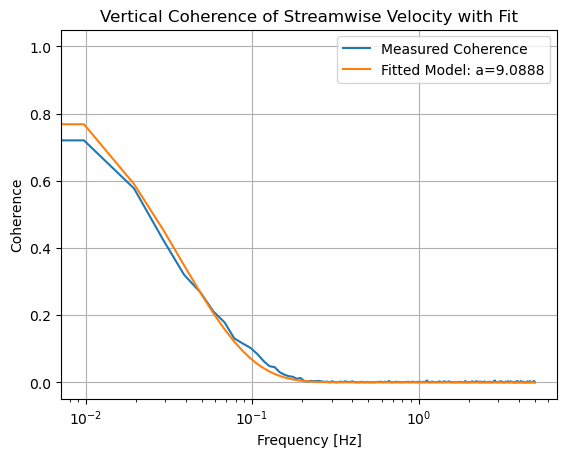

In [ ]:

dz=14
u_mean= ((fastdata_SFC['Ux']+ fastdata_16['Ux'])/2).mean()
def model(f, a):
    return np.exp(-a * dz * f / u_mean)

# Use only the valid (finite) values for curve fitting
mask_fit = np.isfinite(coh) & np.isfinite(f)
popt, pcov = curve_fit(model, f, coh, p0=[1.0])
a_best = popt[0]
y = model(f, a_best)
plt.semilogx(f, coh, label='Measured Coherence')
plt.semilogx(f, y,label=f'Fitted Model: a={a_best:.4f}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity with Fit')
plt.legend()
plt.grid(True)

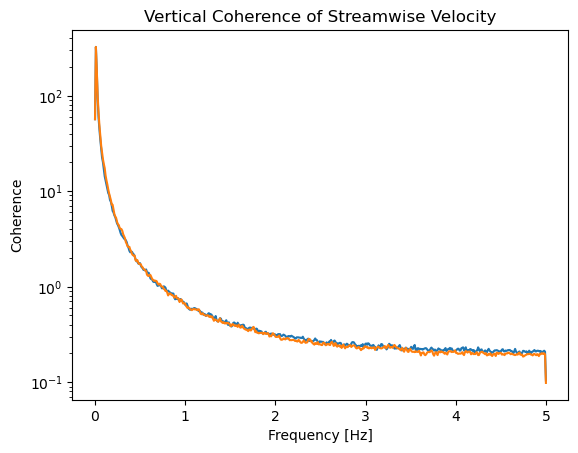

In [58]:
plt.semilogy(f, S11/w_var1**2, label='S11')
plt.semilogy(f, S22/w_var1**2, label='S22')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity')
plt.show()

In [42]:
S11

array([2.24954496e+00, 1.20950342e+01, 6.42328721e+00, 3.13105660e+00,
       1.84653092e+00, 1.34552167e+00, 1.02783138e+00, 8.71014155e-01,
       6.85780014e-01, 5.47096997e-01, 4.83529131e-01, 4.12359742e-01,
       3.62814776e-01, 3.37258435e-01, 3.07019727e-01, 2.84473319e-01,
       2.50768083e-01, 2.29083949e-01, 2.07634717e-01, 1.96851847e-01,
       1.89549471e-01, 1.78748558e-01, 1.65252601e-01, 1.59477403e-01,
       1.45566018e-01, 1.36377441e-01, 1.30411085e-01, 1.30538845e-01,
       1.17705096e-01, 1.15198198e-01, 1.11057819e-01, 1.06720494e-01,
       1.02175140e-01, 1.00108881e-01, 9.17210869e-02, 8.69321404e-02,
       8.77704060e-02, 8.68530348e-02, 8.54466799e-02, 8.25054630e-02,
       7.43553921e-02, 7.32084531e-02, 7.11362048e-02, 7.08447917e-02,
       6.78968359e-02, 6.51200322e-02, 6.25764889e-02, 6.05913501e-02,
       6.08828338e-02, 5.86433108e-02, 5.82667743e-02, 5.59419626e-02,
       5.48830757e-02, 5.50766366e-02, 5.45002811e-02, 5.22412592e-02,
      

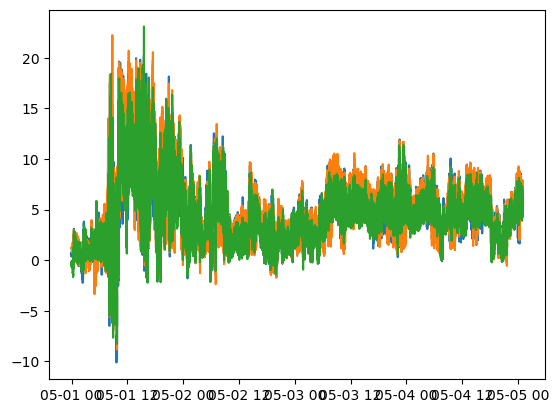

In [53]:
plt.plot(u1)
plt.plot(u2)
plt.plot(fastdata_SFC['Ux'])
